In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from PIL import Image
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import os
import matplotlib.pylab as plt
import numpy as np

In [2]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out		# 这里并没有使用到论文中的shared MLP, 而是直接相加了
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [3]:
def Hswish(x,inplace=True):
    return x * F.relu6(x + 3., inplace=inplace) / 6.

def Hsigmoid(x,inplace=True):
    return F.relu6(x + 3., inplace=inplace) / 6.


# Squeeze-And-ExciteÄ£¿é
class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.se = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y=self.avg_pool(x).view(b, c)
        y=self.se(y)
        y = Hsigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class Bottleneck(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,exp_channels,stride,se='True',nl='HS'):
        super(Bottleneck, self).__init__()
        padding = (kernel_size - 1) // 2
        if nl == 'RE':
            self.nlin_layer = F.relu6
        elif nl == 'HS':
            self.nlin_layer = Hswish
        self.stride=stride
        if se:
            self.se=SEModule(exp_channels)
        else:
            self.se=None
        self.conv1=nn.Conv2d(in_channels,exp_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(exp_channels)
        self.conv2=nn.Conv2d(exp_channels,exp_channels,kernel_size=kernel_size,stride=stride,
                             padding=padding,groups=exp_channels,bias=False)
        self.bn2=nn.BatchNorm2d(exp_channels)
        self.conv3=nn.Conv2d(exp_channels,out_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn3=nn.BatchNorm2d(out_channels)
        # ÏÈ³õÊ¼»¯Ò»¸ö¿ÕÐòÁÐ£¬Ö®ºó¸ÄÔìÆä³ÉÎª²Ð²îÁ´½Ó
        self.shortcut = nn.Sequential()
        # Ö»ÓÐ²½³¤Îª1ÇÒÊäÈëÊä³öÍ¨µÀ²»ÏàÍ¬Ê±²Å²ÉÓÃÌøÔ¾Á¬½Ó(ÏëÒ»ÏÂÌøÔ¾Á´½ÓµÄ¹ý³Ì£¬ÊäÈëÊä³öÍ¨µÀÏàÍ¬Õâ¸öÌøÔ¾Á¬½Ó¾ÍÃ»ÒâÒåÁË)
        if stride == 1 and in_channels != out_channels:
            self.shortcut = nn.Sequential(
                # ÏÂÃæµÄ²Ù×÷¾í»ý²»¸Ä±ä³ß´çºÍÍ¨µÀÊý
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self,x):
        out=self.nlin_layer(self.bn1(self.conv1(x)))
        if self.se is not None:
            out=self.bn2(self.conv2(out))
            out=self.nlin_layer(self.se(out))
        else:
            out = self.nlin_layer(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride == 1 else out
        return out


class MobileNetV3_large(nn.Module):
    # (out_channels,kernel_size,exp_channels,stride,se,nl)
    cfg=[
        (16,3,16,1,False,'RE'),
        (24,3,64,2,False,'RE'),
        (24,3,72,1,False,'RE'),
        (40,5,72,2,True,'RE'),
        (40,5,120,1,True,'RE'),
        (40,5,120,1,True,'RE'),
        (80,3,240,2,False,'HS'),
        (80,3,200,1,False,'HS'),
        (80,3,184,1,False,'HS'),
        (80,3,184,1,False,'HS'),
        (112,3,480,1,True,'HS'),
        (112,3,672,1,True,'HS'),
        (160,5,672,2,True,'HS'),
        (160,5,960,1,True,'HS'),
        (160,5,960,1,True,'HS')
    ]
    def __init__(self,num_classes=5):
        super(MobileNetV3_large,self).__init__()
        self.conv1=nn.Conv2d(3,16,3,2,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(16)
        # ¸ù¾ÝcfgÊý×é×Ô¶¯Éú³ÉËùÓÐµÄBottleneck²ã
        self.layers = self._make_layers(in_channels=16)
        self.conv2=nn.Conv2d(160,960,1,stride=1,bias=False)
        self.bn2=nn.BatchNorm2d(960)
        # ¾í»ýºó²»¸úBN£¬¾ÍÓ¦¸Ã°ÑbiasÉèÖÃÎªTrue
        self.conv3=nn.Conv2d(960,1280,1,1,padding=0,bias=True)
        self.conv4=nn.Conv2d(1280,num_classes,1,stride=1,padding=0,bias=True)

    def _make_layers(self,in_channels):
        layers=[]
        for out_channels,kernel_size,exp_channels,stride,se,nl in self.cfg:
            layers.append(
                Bottleneck(in_channels,out_channels,kernel_size,exp_channels,stride,se,nl)
            )
            in_channels=out_channels
        return nn.Sequential(*layers)

    def forward(self,x):
        out=Hswish(self.bn1(self.conv1(x)))
        out=self.layers(out)
        out=Hswish(self.bn2(self.conv2(out)))
        out=F.avg_pool2d(out,7)
        out=Hswish(self.conv3(out))
        out=self.conv4(out)
        # ÒòÎªÔ­ÂÛÎÄÖÐ×îºóÒ»²ãÊÇ¾í»ý²ãÀ´ÊµÏÖÈ«Á¬½ÓµÄÐ§¹û£¬Î¬¶ÈÊÇËÄÎ¬µÄ£¬ºóÁ½Î¬ÊÇ1£¬ÔÚ¼ÆËãËðÊ§º¯ÊýµÄÊ±ºòÒªÇó¶þÎ¬£¬Òò´ËÔÚÕâÀïÐèÒª×öÒ»¸öresize
        a,b=out.size(0),out.size(1)
        out=out.view(a,b)
        return out

In [4]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)
    

In [5]:
def conv31(ip,op,stride=1):
    return nn.Conv2d(ip,op,kernel_size=3,stride=stride,padding=1,bias=False)
def conv32(ip,op,stride=2):
    return nn.Conv2d(ip,op,kernel_size=3,stride=stride,padding=1,bias=False)
class Upsample(nn.Module):
    def __init__(self,ip,op):
        super(Upsample,self).__init__()
        self.upsample=nn.Sequential(
            conv31(ip,op,1),
            nn.Upsample(scale_factor=2,mode='nearest')
        )
        
    def forward(self,x):
        x=self.upsample(x)
        return x
def backward_hook(module,grad_in,grad_out):
    grad_block.append(grad_out[0].detach())

def farward_hook(module,input,output):
    fmap_block.append(output)

    
def backward2_hook(module,grad_in,grad_out):
    grad_block2.append(grad_out[0].detach())
def backward3_hook(module,grad_in,grad_out):
    grad_block3.append(grad_out[0].detach())
fmap_block=[]
grad_block=[]
grad_block2=[]
grad_block3=[]

In [6]:
def Confusion_mxtrix(labels, predicted, num_classes):
    """
    混淆矩阵定义
    Args:
        labels: [number_total_pictures,1]
        predicted: [number_total_pictures,1] 
        num_classes: 分类数目

    Returns: Confusion_matrix
    """
    Cmatrixs = torch.zeros((num_classes,num_classes))
    stacked = torch.stack((labels, predicted), dim=1)
    for s in stacked:
        a, b = s.tolist()
        Cmatrixs[a, b] = Cmatrixs[a, b] + 1
    return Cmatrixs
def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):
    
    classes = ('NO DR', 'Mild', 'Moderate', 'Severe', 'Proliferative')
    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')

    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()
def Evaluate(Cmatrixs):

    classes = ('NO DR', 'Mild', 'Moderate', 'Severe', 'Proliferative')
    n_classes = Cmatrixs.size(0)
    Prec, Rec = torch.zeros(n_classes+1), torch.zeros(n_classes+1)

    sum_cmt_row = torch.sum(Cmatrixs,dim=1)# 行的和
    sum_cmt_col = torch.sum(Cmatrixs,dim=0)# 列的和
    print("----------------------------------------")
    for i in range(n_classes):
        TP = Cmatrixs[i,i]
        FN = sum_cmt_row[i] - TP
        FP = sum_cmt_col[i] - TP
        # TN = torch.sum(Cmatrixs) - sum_cmt_row[i] - FP
        Prec[i] = TP / (TP + FP)
        Rec[i]  = TP / (TP + FN)
        print("%s"%(classes[i]).ljust(10," "),"Presion=%.3f%%,     Recall=%.3f%%"%(Prec[i],Rec[i]))

    Prec[-1] = torch.mean(Prec[0:-1])
    Rec[-1] = torch.mean(Rec[0:-1])
    print("ALL".ljust(10," "),"Presion=%.3f%%,     Recall=%.3f%%" % (Prec[i], Rec[i]))
    print("----------------------------------------")
#         return Prec,Rec
def MyROC_i(outputs, labels, n=20):
    '''
    ROC曲线计算 绘制每一类的
    Args:
        outputs: [num_labels,num_classes]
        labels: 标签值
        n: 得到n个点之后绘图
    Returns:plot_roc
    '''

    n_total, n_classes = outputs.size()
    labels = labels.reshape(-1,1) # 行向量转为列向量
    T = torch.linspace(0, 1, n)
    TPR, FPR = torch.zeros(n, n_classes+1), torch.zeros(n, n_classes+1)

    for i in range(n_classes):
        for j in range(n):
            mask_1 = outputs[:, i].cpu() > T[j]
            TP_FP = torch.sum(mask_1)
            mask_2 = (labels[:, -1].cpu() == i)
            TP = torch.sum(mask_1 & mask_2)
            FN = n_total / n_classes - TP
            FP = TP_FP - TP
            TN = n_total - n_total / n_classes - FP

            TPR[j,i] = TP / (TP + FN)
            FPR[j,i] = FP / (FP + TN)

    TPR[:,-1] = torch.mean(TPR[:,0:-1],dim=1)
    FPR[:, -1] = torch.mean(FPR[:, 0:-1], dim=1)

    return TPR,FPR

def Plot_ROC_i(TPR, FPR):
    for i in range(5+1):
        if i==5: width=2
        else: width=1
        plt.plot(FPR[:,i],
                 TPR[:,i],
                 linewidth=width,
                 label='classes_%d'%(i))
                
    plt.legend()
    plt.title("ROC")
    plt.grid(True)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.savefig(r'./_ROC_i.png')


In [7]:
labels_value, predicted_value, outputs_value = [],[],[]
correct = 0
total = 0

In [8]:
net = MobileNetV3_large()
net=nn.DataParallel(net)
net.eval()
net.cuda()

DataParallel(
  (module): MobileNetV3_large(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): Bottleneck(
        (conv1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, ep

In [9]:
net.load_state_dict(torch.load(r'/home/fanrz/Desktop/testlarge/weights/best326.pkl'))

In [10]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset

random.seed(1)

class flowerDataset(Dataset):
    # 自定义Dataset类，必须继承Dataset并重写__init__和__getitem__函数
    def __init__(self, data_dir, transform=None):
        """
            花朵分类任务的Dataset
            :param data_dir: str, 数据集所在路径
            :param transform: torch.transform，数据预处理，默认不进行预处理
        """
        # data_info存储所有图片路径和标签（元组的列表），在DataLoader中通过index读取样本
        self.data_info = self.get_img_info(data_dir)
        self.transform = transform

    def __getitem__(self, index):
        path_img, label = self.data_info[index]
        # 打开图片，默认为PIL，需要转成RGB
        img = Image.open(path_img).convert('RGB')
        # 如果预处理的条件不为空，应该进行预处理操作
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data_info)

    # 自定义方法，用于返回所有图片的路径以及标签
    @staticmethod
    def get_img_info(data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                # listdir为列出文件夹下所有文件和文件夹名
                img_names = os.listdir(os.path.join(root, sub_dir))
                # 过滤出所有后缀名为jpg的文件名（那当然也就把文件夹过滤掉了）
#                 img_names = list(filter(lambda x: x.endswith('.png'), img_names))

                # 遍历图片
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    # 在该任务中，文件夹名等于标签名
                    label = sub_dir
                    data_info.append((path_img, int(label)))
        return data_info
    

In [11]:
valid_dir=r'/home/fanrz/Desktop/testlarge/aptos/val2/'
valid_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
valid_data=flowerDataset(data_dir=valid_dir,transform=valid_transform)
valid_loader=DataLoader(dataset=valid_data,batch_size=64,drop_last=True)

In [12]:
print(len(valid_data))

924


In [13]:
for i,data in enumerate(valid_loader):
    images,labels=data
    images=images.cuda()
    labels=labels.cuda()
    outputs=net(images)
    _,predicted = torch.max(outputs.data,1) # tensor([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3], device='cuda:0')
    total=total+labels.size(0)
    correct=correct+(predicted==labels).sum()
#     print(correct) #tensor(14, device='cuda:0')
    if i==0:
        labels_value = labels
        predicted_value = predicted
        outputs_value = F.softmax(outputs.data,dim=1)
    else:
        labels_value = torch.cat((labels_value,labels),0)
        predicted_value = torch.cat((predicted_value,predicted),0)
        outputs_value = torch.cat((outputs_value,F.softmax(outputs.data,dim=1)),0)
correct = correct.cpu().numpy()

In [14]:
print("acc=%.5f%%" % (100 * correct / total))

acc=84.93304%


In [15]:
Cmatrixs = Confusion_mxtrix(labels_value,predicted_value,5)
print(Cmatrixs)

tensor([[167.,   6.,  13.,   3.,   1.],
        [  6., 183.,  22.,   5.,   5.],
        [  1.,  13., 162.,   9.,  13.],
        [  0.,   2.,   9., 114.,   6.],
        [  0.,   4.,  13.,   4., 135.]])


In [16]:
Evaluate(Cmatrixs)

----------------------------------------
NO DR      Presion=0.960%,     Recall=0.879%
Mild       Presion=0.880%,     Recall=0.828%
Moderate   Presion=0.740%,     Recall=0.818%
Severe     Presion=0.844%,     Recall=0.870%
Proliferative Presion=0.844%,     Recall=0.865%
ALL        Presion=0.844%,     Recall=0.865%
----------------------------------------


AttributeError: 'Tensor' object has no attribute 'ndim'

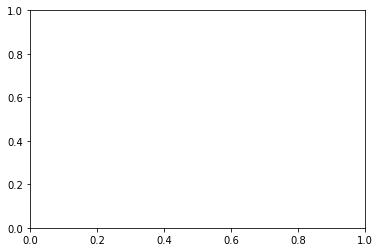

In [17]:
TPR_i, FPR_i = MyROC_i(outputs_value, labels_value)
Plot_ROC_i(TPR_i, FPR_i)

In [18]:
def kappa(matrix):
    matrix=np.array(matrix)
    n=np.sum(matrix)
    sum_po=0
    sum_pe=0
    for i in range(len(matrix[0])):
        sum_po+=matrix[i][i]
        row=np.sum(matrix[i,:])
        col=np.sum(matrix[:,i])
        sum_pe+=row*col
    po=sum_po/n
    pe=sum_pe/(n*n)
    return (po-pe)/(1-pe)

In [19]:
kappa(Cmatrixs)

0.810342421614943